In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import IPython.display as ipd
import copy
import utils

from sklearn.manifold import SpectralEmbedding
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE

In [2]:
tracks = utils.load('fma_metadata/tracks.csv')
genres = utils.load('fma_metadata/genres.csv')
features = utils.load('fma_metadata/features.csv')
echonest = utils.load('fma_metadata/echonest.csv')

In [3]:
echonest["echonest", "audio_features"]

,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence
track_id,,,,,,,,
2,0.416675,0.675894,0.634476,0.010628,0.177647,0.159310,165.922,0.576661
3,0.374408,0.528643,0.817461,0.001851,0.105880,0.461818,126.957,0.269240
5,0.043567,0.745566,0.701470,0.000697,0.373143,0.124595,100.260,0.621661
10,0.951670,0.658179,0.924525,0.965427,0.115474,0.032985,111.562,0.963590
134,0.452217,0.513238,0.560410,0.019443,0.096567,0.525519,114.290,0.894072
...,...,...,...,...,...,...,...,...
124857,0.007592,0.790364,0.719288,0.853114,0.720715,0.082550,141.332,0.890461
124862,0.041498,0.843077,0.536496,0.865151,0.547949,0.074001,101.975,0.476845
124863,0.000124,0.609686,0.895136,0.846624,0.632903,0.051517,129.996,0.496667


In [4]:
tracks.columns

MultiIndex([( 'album',          'comments'),
            ( 'album',      'date_created'),
            ( 'album',     'date_released'),
            ( 'album',          'engineer'),
            ( 'album',         'favorites'),
            ( 'album',                'id'),
            ( 'album',       'information'),
            ( 'album',           'listens'),
            ( 'album',          'producer'),
            ( 'album',              'tags'),
            ( 'album',             'title'),
            ( 'album',            'tracks'),
            ( 'album',              'type'),
            ('artist', 'active_year_begin'),
            ('artist',   'active_year_end'),
            ('artist', 'associated_labels'),
            ('artist',               'bio'),
            ('artist',          'comments'),
            ('artist',      'date_created'),
            ('artist',         'favorites'),
            ('artist',                'id'),
            ('artist',          'latitude'),
          

In [5]:
tag_album = tracks["artist", "tags"].copy(deep=True).reset_index()
tag_album.columns = [''.join(col) for col in tag_album.columns]
tag_album = tag_album.rename(columns={"artisttags" : "tags"})

In [6]:
artist_tag = tag_album[tag_album["tags"].apply(len) != 0]

In [7]:
genres_all_tracks = tracks["track", "genres_all"].copy(deep=True).reset_index()
genres_all_tracks.columns = [''.join(col) for col in genres_all_tracks.columns]
genres_all_tracks = genres_all_tracks.rename(columns={"trackgenres_all" : "genres_all"})

In [8]:
genres_all_tracks["number of genres"] = genres_all_tracks["genres_all"].apply(len)

In [9]:
genres_all_tracks

,track_id,genres_all,number of genres
0,2,[21],1
1,3,[21],1
2,5,[21],1
3,10,[10],1
4,20,"[17, 10, 76, 103]",4
...,...,...,...
106569,155316,"[25, 12]",2
106570,155317,"[25, 12]",2
106571,155318,"[25, 12]",2
106572,155319,"[25, 12]",2


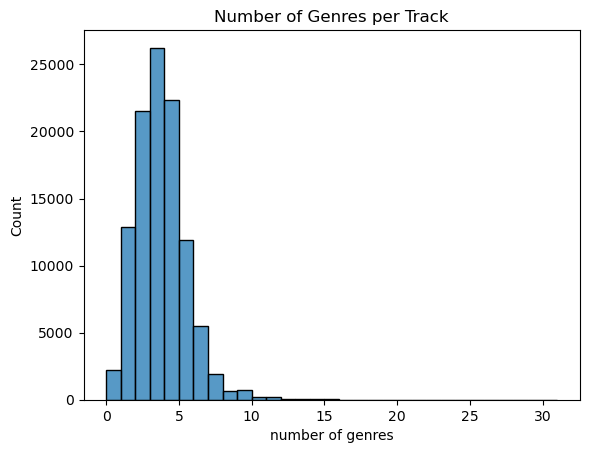

In [10]:
plt.figure()
sns.histplot(data=genres_all_tracks, x="number of genres", binwidth=1)
plt.title("Number of Genres per Track")
plt.show()

In [11]:
features.shape

(106574, 518)

In [ ]:
plt.figure(figsize=(12, 16))
tracks["track"].groupby("genre_top").size().plot(kind="pie", autopct='%1.1f%%', legend=True, textprops={'fontsize': 14}, pctdistance=0.75,
                                                 labeldistance=1.1)
plt.legend(title="Genres", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.text(1.375, -0.5, "total number of tracks: %d\n number of audio features: %d" %(tracks.shape[0], features.shape[1]), fontsize=14, ha='center')

plt.tight_layout()  # Ensures everything fits without overlapping
plt.show()

PCA

In [13]:
features.columns = [' '.join(col) for col in features.columns]
features = features.reset_index()
features = features.drop(columns="track_id")

In [14]:
from sklearn.decomposition import PCA
nc=20
pca = PCA(n_components=nc)
transformed_features = pca.fit_transform(features)
print(pca.explained_variance_ratio_)
print(pca.singular_values_)

[5.61624308e-01 2.92921030e-01 5.13650274e-02 3.10061567e-02
 2.33215468e-02 8.85954222e-03 6.52875216e-03 4.89664648e-03
 3.85295988e-03 3.20438136e-03 2.75348699e-03 1.95748292e-03
 1.06534220e-03 8.81586310e-04 7.25790163e-04 4.48302211e-04
 3.81835383e-04 3.44946279e-04 3.22736441e-04 3.07269270e-04]
[656309.21303699 473980.88698749 198481.17153034 154208.92910578
 133740.89590814  82431.11869139  70762.08875271  61282.28189279
  54360.41906209  49574.42109164  45954.39647573  38746.68424259
  28584.46833385  26002.67161279  23593.43047297  18542.61549891
  17112.90099443  16265.27030765  15732.92800989  15351.29851349]


In [15]:
label = tracks["track", "genre_top"].reset_index()
label.columns = [''.join(col) for col in label.columns]
label = label.rename(columns={"trackgenre_top" : "genre"})
label = label.drop(columns="track_id")

In [16]:
transformed_features = pd.DataFrame(data=transformed_features, columns=["pc%d" %i for i in range(1, nc+1)])

In [17]:
pca_df = pd.concat([transformed_features, label], axis=1)

In [18]:
pca_df

,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8,pc9,pc10,...,pc12,pc13,pc14,pc15,pc16,pc17,pc18,pc19,pc20,genre
0,1454.916960,-306.092911,-71.329221,-451.735639,-318.251436,-185.114075,-86.295955,-122.699129,-32.764707,-19.819065,...,-7.714465,71.777123,32.888350,0.537529,18.771697,-3.611397,-9.424649,16.969273,14.201201,Hip-Hop
1,2112.006942,573.436823,87.284532,-342.654073,-295.952680,-293.542882,-230.134415,35.844273,-13.829441,-20.228865,...,-25.060017,144.369614,44.067542,-5.868483,-9.596766,21.662124,-14.719439,14.347302,4.775106,Hip-Hop
2,834.260162,-34.211569,-13.311043,-377.407321,-324.251013,-29.846700,-37.378959,106.066616,152.499186,-43.683773,...,-67.538696,59.943967,6.370766,-0.021469,4.145336,17.892043,-15.008729,26.983513,15.869846,Hip-Hop
3,281.486794,722.298277,176.234670,-607.314170,140.753420,-143.618982,141.523235,-357.644344,-100.088024,-92.388832,...,73.923899,-57.448568,11.112383,-1.246863,-56.713719,21.867792,-8.330162,8.017577,-2.091474,Pop
4,3104.408724,-616.657241,-170.734611,-353.261298,120.759723,739.041073,-150.847147,160.412915,-44.950610,61.015276,...,-219.346291,-26.901805,-4.868382,-2.169482,-13.846905,-21.463084,21.307924,-68.027504,-48.194626,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106569,-1058.973890,42.973794,-573.929079,-214.726864,32.043895,190.478977,27.579722,36.377630,-144.085339,-74.513568,...,-8.348562,-32.343450,-30.074539,7.451359,-7.108729,41.053289,-1.788805,4.995888,0.494793,Rock
106570,-1566.480936,-3002.074538,489.770714,98.203174,-159.230713,101.940052,221.809854,-49.759666,-64.962793,-52.570288,...,-20.812221,-30.227579,-9.966506,1.629955,-1.005019,4.395588,5.966657,-7.510334,-13.607956,Rock
106571,-299.144805,-5.213534,-458.092823,-185.570783,121.334085,58.592569,-173.967723,130.327354,-104.658513,-47.298785,...,-8.837210,-82.306361,-37.097502,6.790235,24.444381,19.921529,-3.893034,11.155613,1.347604,Rock
106572,-5.369701,-169.769330,-652.930778,107.578963,115.318066,251.204912,-19.083293,72.670694,-158.585887,-35.163059,...,-62.167454,-50.527102,-39.466334,6.727310,-3.906460,23.697994,-5.615125,7.436161,-0.142316,Rock


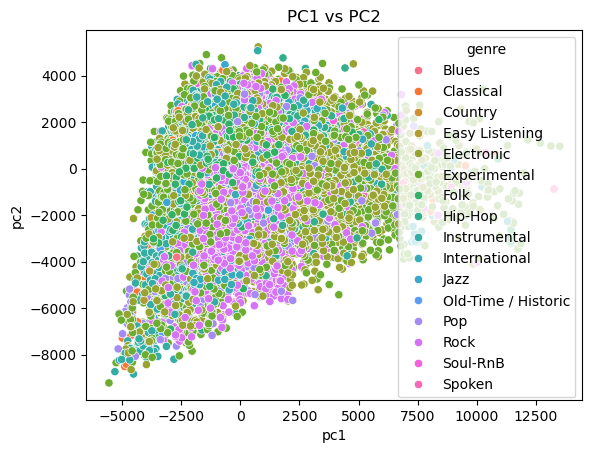

In [19]:
plt.figure()
sns.scatterplot(data=pca_df, x="pc1", y="pc2", hue="genre")
plt.title("PC1 vs PC2")
plt.show()

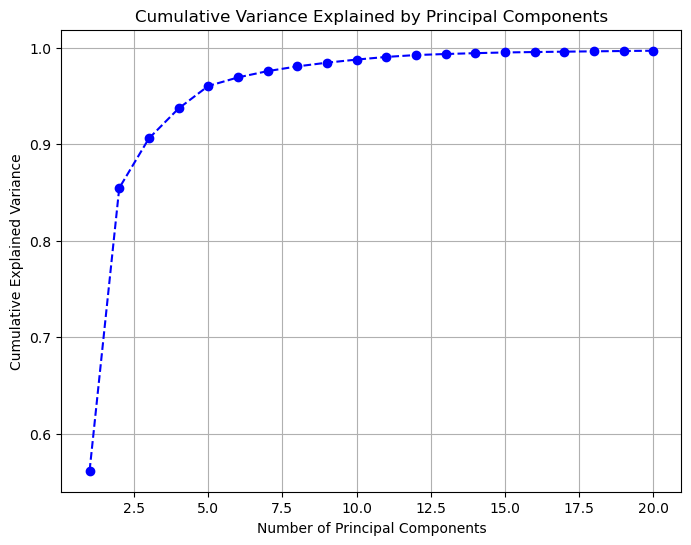

In [20]:
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
plt.figure(figsize=(8, 6))
plt.plot(range(1, nc+1), cumulative_variance, marker='o', linestyle='--', color='b')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Variance Explained by Principal Components')
# Show grid for better readability
plt.grid(True)
plt.show()

TSNE

/opt/homebrew/Caskroom/miniconda/base/envs/ml_project/lib/python3.11/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


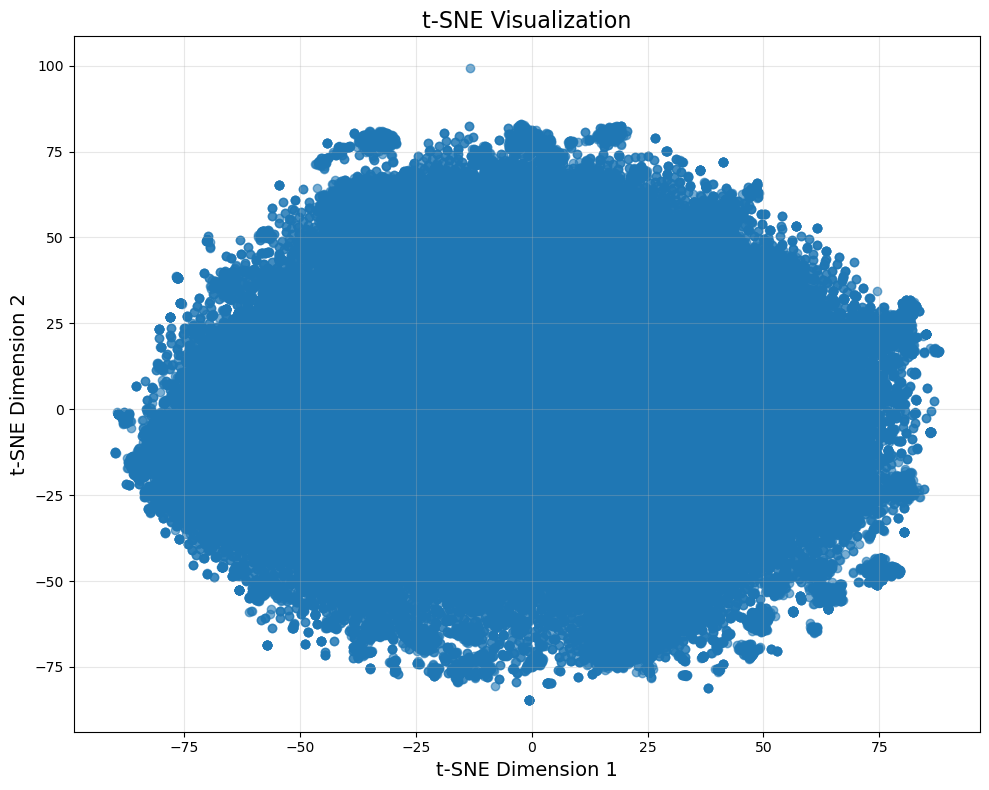

In [ ]:
# Handle missing values if any
data = features.dropna()

# Standardize the features
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

# Apply t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
tsne_results = tsne.fit_transform(data_scaled)

# Create a DataFrame for visualization
tsne_df = pd.DataFrame(tsne_results, columns=['TSNE1', 'TSNE2'])

# Optional: Add genre or labels for coloring (if available)
if 'track.7' in tracks.columns:
    tsne_df['Genre'] = tracks.loc[data.index, 'track.7']

In [43]:
# Add genre labels for coloring (if not already added)
# Reset index for both DataFrames
data_ = data.reset_index(drop=True)
tracks_ = tracks.reset_index(drop=True)

# Now select the genre column based on aligned indices

tsne_df['Genre'] = tracks_["track", "genre_top"].loc[data_.index]

In [44]:
tsne_df

,TSNE1,TSNE2,Genre
0,-2.540634,33.603745,Hip-Hop
1,-15.928009,37.101994,Hip-Hop
2,-27.707121,21.137959,Hip-Hop
3,-36.800423,-15.039506,Pop
4,-2.540744,12.482625,NaN
...,...,...,...
106569,-21.564518,-47.960007,Rock
106570,-21.073648,-27.425957,Rock
106571,-23.106386,-26.107700,Rock
106572,-23.161854,-26.163982,Rock


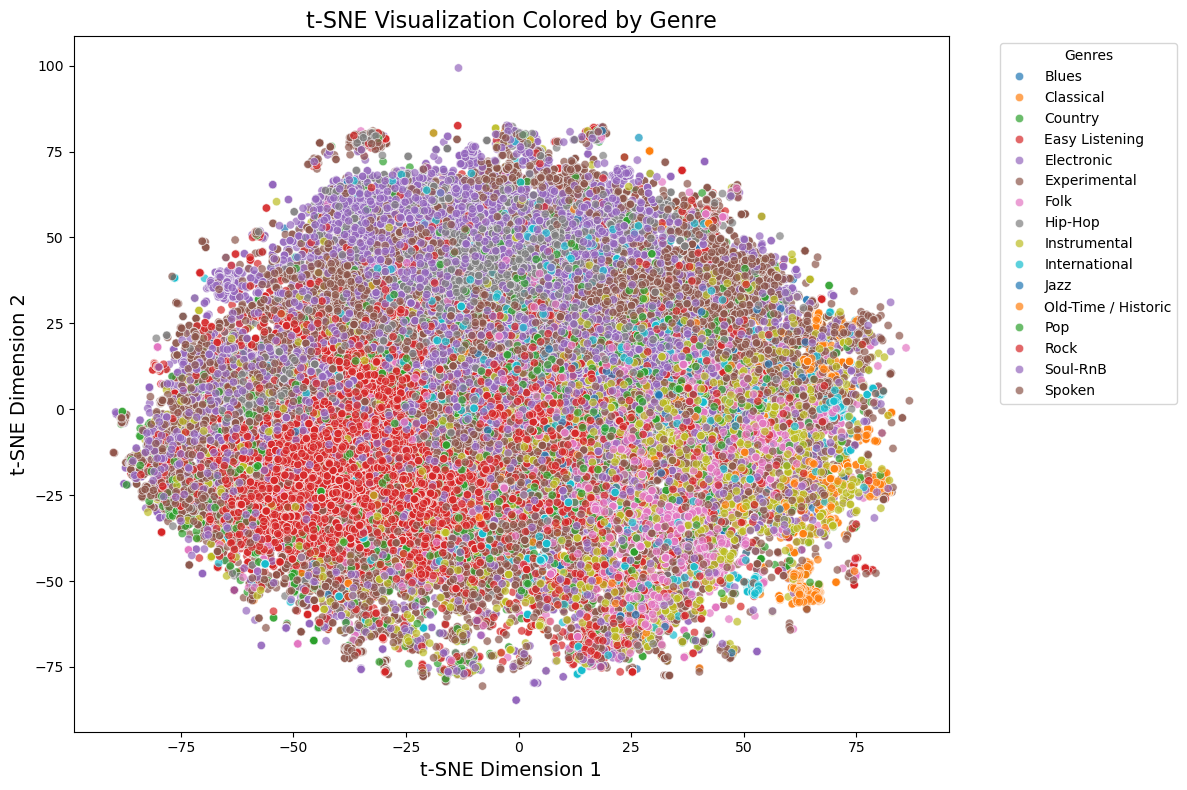

In [ ]:
# Plot t-SNE results using Seaborn
plt.figure(figsize=(12, 8))
sns.scatterplot(
    x='TSNE1',
    y='TSNE2',
    hue='Genre',
    palette='tab10',  # Adjust palette for more colors if needed
    data=tsne_df,
    alpha=0.7
)

# Add labels, title, and legend
plt.title("t-SNE Visualization Colored by Genre", fontsize=16)
plt.xlabel("t-SNE Dimension 1", fontsize=14)
plt.ylabel("t-SNE Dimension 2", fontsize=14)
plt.legend(title="Genres", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


Spectral Embedding

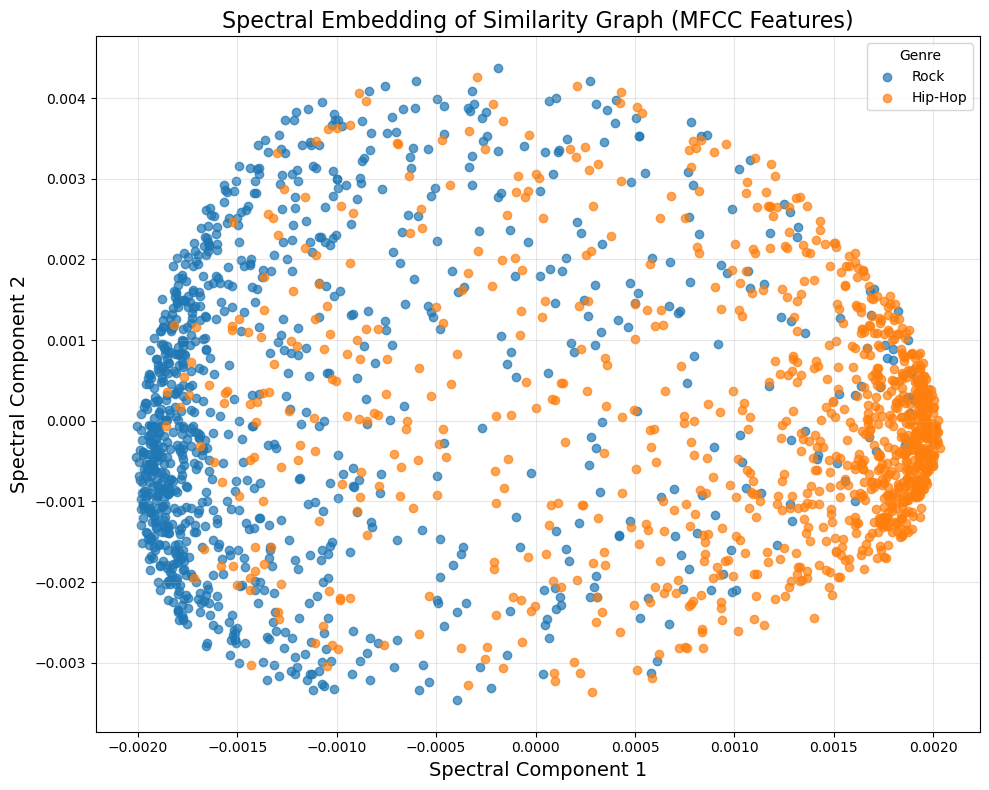

In [ ]:
tracks = utils.load('fma_metadata/tracks.csv')
features = utils.load('fma_metadata/features.csv')

subset = tracks.index[tracks['set', 'subset'] <= 'small']

tracks = tracks.loc[subset]
features_all = features.loc[subset]

# Filter data for two genres
selected_genres = ['Rock', 'Hip-Hop']  # Replace with the desired genres
filtered_tracks = tracks[tracks["track", "genre_top"].isin(selected_genres)]  # Filter tracks by genre
filtered_tracks.columns = [''.join(col) for col in filtered_tracks.columns]
filtered_tracks = filtered_tracks.rename(columns={"trackgenre_top" : "genre"}).reset_index()
filtered_tracks = filtered_tracks[["track_id", "genre"]]

# Extract MFCC features and standardize them
mfcc_columns = [col for col in features.columns if 'mfcc' in col]  # Replace with actual MFCC feature columns
mfcc_features = features[mfcc_columns].dropna()

mfcc_features.columns = [' '.join(col) for col in mfcc_features.columns]
mfcc_features = mfcc_features.reset_index()

mfcc_features = mfcc_features.merge(filtered_tracks, how="inner", on="track_id")
mfcc_features = mfcc_features.dropna()
genres = mfcc_features["genre"]
mfcc_features = mfcc_features.drop(columns=["track_id", "genre"])

scaler = StandardScaler()
mfcc_scaled = scaler.fit_transform(mfcc_features)

# Compute similarity matrix using cosine similarity
similarity_matrix = cosine_similarity(mfcc_scaled)

if np.isnan(similarity_matrix).any():
    print("NaNs detected in similarity_matrix, replacing with zeros.")
    similarity_matrix = np.nan_to_num(similarity_matrix)

similarity_matrix = np.clip(similarity_matrix, 0, None)


# Perform spectral embedding
embedding = SpectralEmbedding(n_components=2, affinity='precomputed', random_state=42)
spectral_coords = embedding.fit_transform(similarity_matrix)

# Plot the results, colored by genre
filtered_tracks = filtered_tracks.reset_index(drop=True)

plt.figure(figsize=(10, 8))
for genre in selected_genres:
    indices = genres == genre
    plt.scatter(
        spectral_coords[indices, 0],
        spectral_coords[indices, 1],
        label=genre,
        alpha=0.7
    )

plt.title("Spectral Embedding of Similarity Graph (MFCC Features)", fontsize=16)
plt.xlabel("Spectral Component 1", fontsize=14)
plt.ylabel("Spectral Component 2", fontsize=14)
plt.legend(title="Genre")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()